# Model training

## Import packages

In [1]:
import tensorflow as tf
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import random
import re
import matplotlib.pyplot as plt
from scipy import sparse
from tqdm import tqdm

# Deep learning: 
from keras.models import Input, Model
from keras.layers import Dense

In [2]:
#Activate tensorboard extension
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%load_ext tensorboard

#Import necessary libs
import tensorflow_datasets as tfds
from tensorboard.plugins import projector

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-05-16 12:18:43.456855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 12:18:43.499528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 12:18:43.500130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Read data

In [4]:
# Datensatz einlesen
df = pd.read_csv('data/out.csv')

## Transform dataframe

In [5]:
# Dataframe mit 3 Spalten. Werden so gejoint, dass ein neues Dataframe mit ein Haiku pro Zeile erstellt wird
df = df[['0', '1', '2']].agg(lambda x: ' '.join(x.values), axis=1)
# Dataframe to list [[]] -> []
haikus = df.values.tolist()

# ---------------------------------------------------
# Erst mal nur mit 1000 Haikus!
haikus = haikus[:1000]
# ---------------------------------------------------

In [25]:
# alle Haikus in Array
print(haikus[-10:])
number_of_haikus = len(haikus)
print('number of haikus: ' + str(number_of_haikus))

['why are you letting  your infant have table food so early stop please', 'never trust virgin  east coast they dont care unless u are elderly', 'paces wrigley field  express is a game changer and a life saver', 'now that the secrets  out i can stop living this dumb secretive life', 'everyday i thank  god for a roof over my head and my bills paid', 'nobody talk to  me for the rest of the day im going to sleep', 'i found the cutest  set from vs i hope its in leeds tomorrow', 'bother me tell me  awful things you know i love it when you do that', 'walmart kid doesnt  even tap his foot in time and that is the tea', 'me when people ask  if i got highlights but ive never dyed my hair']
number of haikus: 1000


## Clean text 

In [7]:
huge_string = ' SATZENDE SATZANFANG '.join(haikus)
huge_string_cleaned = re.sub('[.,_]', '', huge_string)

# TODO remove stopwords!

huge_list = huge_string_cleaned.split(' ')

In [8]:
#Get vocabulary
vocab = sorted(set(huge_list))
print(vocab[:20])
vocab_size = len(vocab)
print(vocab_size)

['', 'SATZANFANG', 'SATZENDE', 'a', 'aaron', 'abandon', 'abandoning', 'abbey', 'aboating', 'abound', 'about', 'above', 'absent', 'absolute', 'absolutely', 'abstract', 'accepted', 'according', 'acrid', 'across']
3454


In [9]:
vocab = np.array(vocab)

## Create context windows

In [10]:
# Defining the window for context
window = 3

word_lists = []

# Creating a context dictionary
for i, word in enumerate(huge_list):
    for w in range(window):
        # Getting the context that is ahead by *window* words
        if i + 1 + w < len(huge_list): 
            word_lists.append([word] + [huge_list[(i + 1 + w)]])
        # Getting the context that is behind by *window* words    
        if i - w - 1 >= 0:
            word_lists.append([word] + [huge_list[(i - w - 1)]])

In [11]:
print(word_lists[-100:])

[['his', 'tap'], ['his', 'in'], ['his', 'even'], ['foot', 'in'], ['foot', 'his'], ['foot', 'time'], ['foot', 'tap'], ['in', 'time'], ['in', 'foot'], ['in', 'and'], ['in', 'his'], ['time', 'and'], ['time', 'in'], ['time', 'that'], ['time', 'foot'], ['and', 'that'], ['and', 'time'], ['and', 'is'], ['and', 'in'], ['that', 'is'], ['that', 'and'], ['that', 'the'], ['that', 'time'], ['is', 'the'], ['is', 'that'], ['is', 'tea'], ['is', 'and'], ['the', 'tea'], ['the', 'is'], ['the', 'SATZENDE'], ['the', 'that'], ['tea', 'SATZENDE'], ['tea', 'the'], ['tea', 'SATZANFANG'], ['tea', 'is'], ['SATZENDE', 'SATZANFANG'], ['SATZENDE', 'tea'], ['SATZENDE', 'me'], ['SATZENDE', 'the'], ['SATZANFANG', 'me'], ['SATZANFANG', 'SATZENDE'], ['SATZANFANG', 'when'], ['SATZANFANG', 'tea'], ['me', 'when'], ['me', 'SATZANFANG'], ['me', 'people'], ['me', 'SATZENDE'], ['when', 'people'], ['when', 'me'], ['when', 'ask'], ['when', 'SATZANFANG'], ['people', 'ask'], ['people', 'when'], ['people', ''], ['people', 'me'], ['

## One-hot encode

In [12]:
# Creating the dictionary for the unique words
unique_word_dict = {}
for i, word in enumerate(vocab):
    unique_word_dict.update({
        word: i
    })
    
print(unique_word_dict.get('a'))

3


In [13]:
# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

In [14]:
# word_lists1 = word_lists[:int(len(word_lists)/10000)]
print('len(word_lists): ' + str(len(word_lists)))
#print('len(word_lists1): ' + str(len(word_lists1)))


# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])      #First word in tupel
    context_word_index = unique_word_dict.get(word_list[1])   #Second word in Tupel

    # Creating the placeholders   
    X_row = np.zeros(n_words,dtype=bool)       #set type to bool to save memory
    Y_row = np.zeros(n_words,dtype=bool)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)
    
#! Hier schmiert der Kernel bei der Iteration immer ab.. 

len(word_lists): 59598


59598it [00:00, 118834.08it/s]


In [15]:
# Converting the matrices into an array
X = np.asarray(X)
Y = np.asarray(Y)

## The model

In [16]:
# Defining the size of the embedding (Often in practice, pre-trained word embeddings are used with typical word embedding dimensions being either 100, 200 or 300.)
embed_size = 200

# Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)

2022-05-16 12:18:49.365992: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-16 12:18:49.367669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 12:18:49.368322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 12:18:49.368884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [17]:

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [18]:
# Optimizing the network weights
model.fit(
    x=X, 
    y=Y, 
    batch_size=256,
    epochs=500
    )



Epoch 1/500
233/233 [==============================] - 2s 5ms/step - loss: 6.8691
Epoch 2/500
233/233 [==============================] - 1s 5ms/step - loss: 6.2748
Epoch 3/500
233/233 [==============================] - 1s 5ms/step - loss: 6.2277
Epoch 4/500
233/233 [==============================] - 1s 5ms/step - loss: 6.1761
Epoch 5/500
233/233 [==============================] - 1s 5ms/step - loss: 6.1090
Epoch 6/500
233/233 [==============================] - 1s 5ms/step - loss: 6.0282
Epoch 7/500
233/233 [==============================] - 1s 5ms/step - loss: 5.9354
Epoch 8/500
233/233 [==============================] - 1s 5ms/step - loss: 5.8333
Epoch 9/500
233/233 [==============================] - 1s 5ms/step - loss: 5.7207
Epoch 10/500
233/233 [==============================] - 1s 4ms/step - loss: 5.6002
Epoch 11/500
233/233 [==============================] - 1s 5ms/step - loss: 5.4745
Epoch 12/500
233/233 [==============================] - 1s 5ms/step - loss: 5.3449
Epoch 13/500


In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3454)]            0         
                                                                 
 dense (Dense)               (None, 200)               691000    
                                                                 
 dense_1 (Dense)             (None, 3454)              694254    
                                                                 
Total params: 1,385,254
Trainable params: 1,385,254
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

In [21]:
# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: np.asarray(weights[unique_word_dict.get(word)])
        })

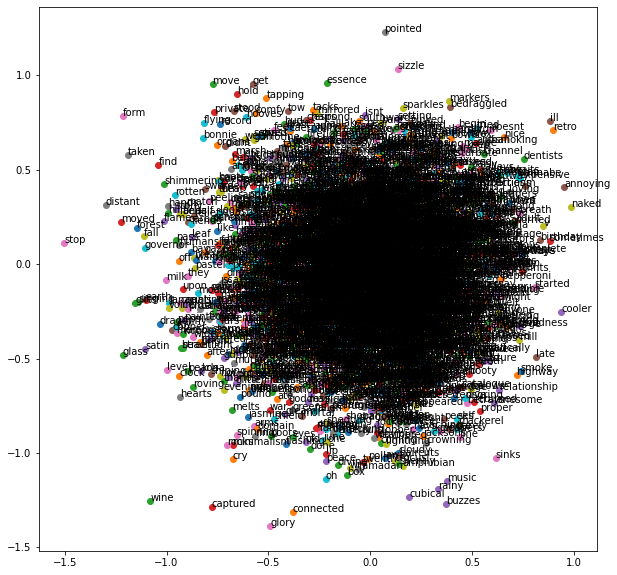

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for word in list(unique_word_dict.keys()):
  coord = embedding_dict.get(word)
  plt.scatter(coord[0], coord[1])
  plt.annotate(word, (coord[0], coord[1]))

In [23]:
# Save metadata into tsv file
pd.DataFrame(embedding_dict.keys()).to_csv("model_dir/metadata.tsv", sep = '\t', index=False)

In [24]:
# Save embeddings_vectors into tsv file
pd.DataFrame(embedding_dict.values()).to_csv("model_dir/vectors_2.tsv", sep = '\t', index=False)